<a href="https://colab.research.google.com/github/mactat/DL-IQIWA/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import random
from PIL import Image 
import copy

from torch import nn, Tensor
from torch.distributions import Distribution

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F

## Load Dataset ##

In [2]:

transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 1

# Train and validation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

#Test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Settings ##

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cpu


## Model ##

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1) # out: c x 16 x 16
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upSample = nn.Upsample(size=(2,2))
        self.conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        # x = self.upSample(x)
        # x = torch.sigmoid(self.conv2(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Train ##


In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = []
    for batch, (image_batch, _) in enumerate(train_dataloader):
        image_batch = image_batch.to(device)

        # Compute prediction error
        pred = model(image_batch)
        loss = loss_fn(pred, image_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(image_batch)
            train_loss.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return (sum(train_loss))/len(train_loss)

In [6]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            pred = model(image_batch)
            test_loss += loss_fn(pred, image_batch).item()
    test_loss /= num_batches
    
    return test_loss

In [7]:
# Parameters for training
vae = VariationalAutoencoder()
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

learning_rate = 1e-3
num_epochs = 3

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

Number of parameters: 5675


In [8]:
val_loss_avg = []
train_loss_avg = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, vae, criterion, optimizer)
    val_loss = validate(validation_dataloader, vae, criterion)
    
    train_loss_avg.append(train_loss)
    val_loss_avg.append(val_loss)
    
    print(f"Train loss: {train_loss:>8f}\nTest Error: {val_loss:>8f} \n")
    
print("Done!")

Epoch 1
-------------------------------
train loss: 0.103456  [    0/50000]
train loss: 0.011297  [10000/50000]
train loss: 0.001426  [20000/50000]
train loss: 0.001904  [30000/50000]
train loss: 0.001686  [40000/50000]
Train loss: 0.023954
Test Error: 0.002483 

Epoch 2
-------------------------------
train loss: 0.002878  [    0/50000]
train loss: 0.002226  [10000/50000]
train loss: 0.000491  [20000/50000]
train loss: 0.001956  [30000/50000]
train loss: 0.001624  [40000/50000]
Train loss: 0.001835
Test Error: 0.002096 

Epoch 3
-------------------------------
train loss: 0.002568  [    0/50000]
train loss: 0.002122  [10000/50000]
train loss: 0.001393  [20000/50000]
train loss: 0.003313  [30000/50000]
train loss: 0.002075  [40000/50000]
Train loss: 0.002294
Test Error: 0.001905 

Done!


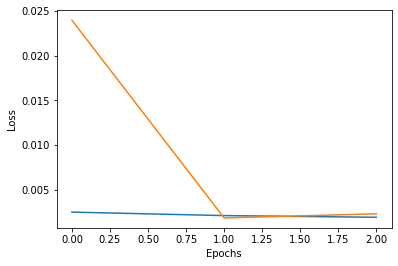

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(val_loss_avg)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

In [10]:
test_loss = validate(test_dataloader, vae, criterion)
print('average reconstruction error: %f' % (test_loss))

average reconstruction error: 0.001905


## Visualization

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image_tensor(img):
    img = torchvision.utils.make_grid(img,10,5)
    img = to_img(img)
    npimg = img.numpy()
    show_image_numpy(img)

def show_image_numpy(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def make_prediction(images, model, visualize = True):

    with torch.no_grad():
    
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images, 10, 5).numpy()
        if visualize:
          plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
          plt.show()
        return np_imagegrid

Original images


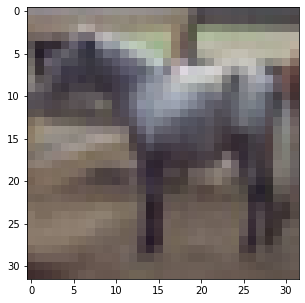

VAE reconstruction:


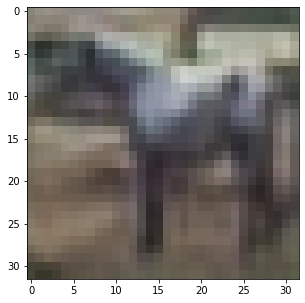

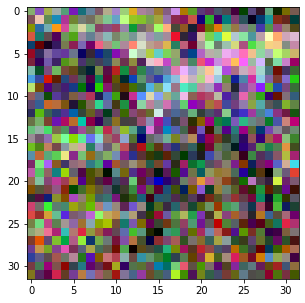

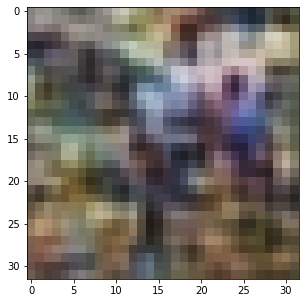

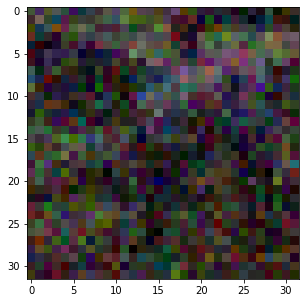

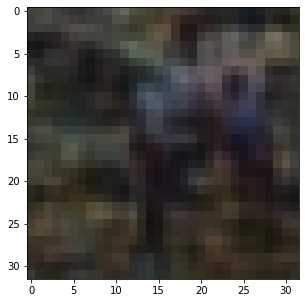

array([[[0.2545555 , 0.26689398, 0.28716248, ..., 0.16375807,
         0.15277962, 0.19966237],
        [0.24687213, 0.28153607, 0.2928067 , ..., 0.13798092,
         0.11057951, 0.14705935],
        [0.2502885 , 0.25762054, 0.24855405, ..., 0.27734384,
         0.205424  , 0.19745739],
        ...,
        [0.21109028, 0.21783215, 0.26757327, ..., 0.245672  ,
         0.25684598, 0.23170528],
        [0.19470535, 0.17010505, 0.16871725, ..., 0.21784437,
         0.1934    , 0.18300433],
        [0.2307528 , 0.17678554, 0.15885542, ..., 0.17429782,
         0.15675765, 0.1759029 ]],

       [[0.27412218, 0.28092122, 0.30202115, ..., 0.15215574,
         0.14851627, 0.21872264],
        [0.2543807 , 0.2897953 , 0.3058608 , ..., 0.12861195,
         0.10381161, 0.15523042],
        [0.25329828, 0.25137177, 0.24408983, ..., 0.25442132,
         0.18601   , 0.19333401],
        ...,
        [0.17151971, 0.16316068, 0.20921041, ..., 0.20054027,
         0.21499448, 0.21289141],
        [0.1

In [13]:
# visualization one by one
plt.rcParams["figure.figsize"] = [5,5]

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image_tensor(images)

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
make_prediction(images, vae)

# random noise
noise = np.random.normal(0, 0.2, images.numpy()[0].shape)
images = images + noise
show_image_tensor(images)

# reconstruction of random noise
images = images.float()
make_prediction(images, vae)

# darker image
level = 50 #%
images = images/(100/level)
show_image_tensor(images)

# reconstruction of darker image
images = images.float()
make_prediction(images, vae)

In [15]:
# all images

def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))


images = []
predictions = []
print(len(test_dataloader))

with torch.no_grad():
  for image, label in iter(test_dataloader):

    #lets make it noisy
    noise = np.random.normal(0, 0.2, image.numpy()[0].shape)
    image = image + noise 
    image = image.float()
    #====================
    
    prediction = make_prediction(image,vae,visualize=False)
    img = torchvision.utils.make_grid(image,10,5)
    img = to_img(img)
    npimg = img.numpy()
    images.append(npimg)
    predictions.append(prediction)

images = np.asarray(images)
images = np.moveaxis(images, 1, 3)
predictions = np.asarray(predictions)
predictions = np.moveaxis(predictions, 1, 3)

plt.rcParams["figure.figsize"] = [200,200]
plt.imshow(sbscompare(images, predictions, 20, 20))
plt.axis('off')
plt.show()

10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
